In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import time

## Exploration data analysis and re-processing

Load the csv file and visually inspect if the data is ready for analysis.

In [2]:
data = pd.read_csv('No-show-Issue-Comma-300k.csv')
#data.head(50)

Check the dimension of the data set, to make sure the number of rows is 300K and verify the number of columns

In [3]:
print(data.shape)

(300000, 15)


Do a check if the data set is complete -- no missing values or NaN. 

In [4]:
#Print total number of NaNs
data.isnull().sum()

Age                        0
Gender                     0
AppointmentRegistration    0
ApointmentData             0
DayOfTheWeek               0
Status                     0
Diabetes                   0
Alcoolism                  0
HiperTension               0
Handcap                    0
Smokes                     0
Scholarship                0
Tuberculosis               0
Sms_Reminder               0
AwaitingTime               0
dtype: int64

From visual analysis, it is a good idea to enumerate the following columns:
* Gender (M/F)
* DayOfTheWeek
* Status

In [5]:
gender_map = {'M': 1, 'F': 2}
DayOfTheWeek_map = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
Status_map = {'Show-Up': 1, 'No-Show': 0}

data['Gender'] = data.Gender.map(gender_map)
data['DayOfTheWeek'] = data.DayOfTheWeek.map(DayOfTheWeek_map)
data['Status'] = data.Status.map(Status_map)

Rename the columns to correct the spelling error:
* Alcoolism
* HiperTension
* Handcap
* ApointmentData

In [6]:
data = data.rename(columns = {'Alcoolism':'Alchoholism', 
                              'HiperTension' : "Hypertension", 
                              'Handcap':'Handicap', 
                              'ApointmentData':'AppointmentDate'})

In addition, I think we should break the columns **AppointmentRegistration** and **AppointmentData** into date and time columns using numpy datetime64 function. I apply the np.datatime64 function on these 2 columns and further split each column into the Date and Time fields. After that, I drop the original AppointmentRegistration and AppointmentData fields

In [7]:
data.AppointmentRegistration = data.AppointmentRegistration.apply(np.datetime64)
data.AppointmentDate = data.AppointmentDate.apply(np.datetime64)

data['AppointmentRegistration-Date'] = pd.to_datetime(data.AppointmentRegistration).dt.date
data['AppointmentRegistration-Time'] = pd.to_datetime(data.AppointmentRegistration).dt.time

data['AppointmentDate-Date'] = pd.to_datetime(data.AppointmentDate).dt.date
data['AppointmentDate-Time'] = pd.to_datetime(data.AppointmentDate).dt.time

data = data.drop('AppointmentRegistration', axis=1)
data = data.drop('AppointmentDate', axis=1)

data.head(10)

,Age,Gender,DayOfTheWeek,Status,Diabetes,Alchoholism,Hypertension,Handicap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime,AppointmentRegistration-Date,AppointmentRegistration-Time,AppointmentDate-Date,AppointmentDate-Time
0,19,1,3,1,0,0,0,0,0,0,0,0,-29,2014-12-16,14:46:25,2015-01-14,00:00:00
1,24,2,3,1,0,0,0,0,0,0,0,0,-1,2015-08-18,07:01:26,2015-08-19,00:00:00
2,4,2,2,1,0,0,0,0,0,0,0,0,-1,2014-02-17,12:53:46,2014-02-18,00:00:00
3,5,1,4,1,0,0,0,0,0,0,0,1,-15,2014-07-23,17:02:11,2014-08-07,00:00:00
4,38,1,2,1,0,0,0,0,0,0,0,1,-6,2015-10-21,15:20:09,2015-10-27,00:00:00
5,5,2,2,0,0,0,0,0,0,0,0,1,-35,2014-06-17,06:47:27,2014-07-22,00:00:00
6,46,2,2,1,0,0,0,0,0,0,0,1,-18,2015-06-19,19:53:58,2015-07-07,00:00:00
7,4,2,5,1,0,0,0,0,0,1,0,1,-14,2015-08-07,08:19:19,2015-08-21,00:00:00
8,20,2,2,1,0,0,0,0,0,0,0,0,-14,2014-10-14,11:46:36,2014-10-28,00:00:00
9,51,2,2,1,1,0,1,0,0,0,0,1,-4,2014-06-13,07:50:43,2014-06-17,00:00:00


From the resulting data frame, we can see that the entire **AppointmentData-Time** column is 0. This column is definitely not useful, so it is dropped from the dataframe. In addition, the **AwaitingTime** captures the information of no. of days between the Appointment Registration Date and Appointment Date. In this version of analsis, we assume that the Appointment Registration Date and Appoint Date are not important and not used in this analysis. A possible enhancement to the analysis is to see if the **AppointmentDate**, **Appointment Registration-Date** and **AppointmentRegistration-Time** affects the No-Show status.

In [8]:
data.drop('AppointmentDate-Time', axis=1, inplace=True)
data.drop('AppointmentDate-Date', axis=1, inplace=True)
data.drop('AppointmentRegistration-Date', axis=1, inplace=True)
data.drop('AppointmentRegistration-Time', axis=1, inplace=True) 

Take a look at the breakdown of the target class values (status). About 30% of the status is 0 (No-Show)

In [9]:
print(data.groupby('Status').size())

Status
0     90731
1    209269
dtype: int64


In [10]:
data.to_csv('No-show-Issue-Comma-300k_cleaned.csv', index=False)

## Baseline algorithm checking

Based on a certain set of conditions, we intend to predict the likelihood of appointment no-show (either 1 or 0). This is a binary classification problem, and a few algorithms are appropriate for use. However, we do not know which one will perform the best at the point. The best is to do a quick test on the few appropriate algorithms without tuning to get an early indication of each of them perform. We will use 10 fold cross validation for each testing.

I will use the non-linear algorithms for testing, namely: **Classification and Regression Trees (CART)**, **Linear Support Vector Machines (SVM)**, **Gaussian Naive Bayes (NB)** and **k-Nearest Neighbors (KNN)**.

In [11]:
models_list = []
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('Linear SVM', LinearSVC())) 
models_list.append(('NB', GaussianNB()))
models_list.append(('KNN', KNeighborsClassifier()))

## Trial run of algorithms on sampled dataset

This analysis is done on my Macbook Air with 8GB. With 300K rows, the algorithm performance on the dataset is extremely slow. Since the intention here is to see how the algorithms perform indicatively, I will use just 5% sample from the main dataset (~about 10,000 rows). Then these selected rows will be used to test against the 4 non-linear algorithms.

The sampled data set is spliited into 2 - Y and X, where Y holds the target variable 'Status'.

In [12]:
data = pd.read_csv('No-show-Issue-Comma-300k_cleaned.csv')
sample_size = 10000
data_sample = data.sample(n=sample_size, replace=False, random_state= 123)

# Create arrays for the features and the response variable
Y_sample = data_sample['Status'].values
X_sample = data_sample.drop('Status', axis=1).values

In [13]:
num_folds = 10
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds, random_state=123)
    start = time.time()
    cv_results = cross_val_score(model, X_sample, Y_sample, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))


CART: 0.574000 (0.014526) (run time: 0.244556)
Linear SVM: 0.525600 (0.164432) (run time: 5.153024)
NB: 0.659400 (0.013756) (run time: 0.045433)
KNN: 0.647000 (0.012767) (run time: 0.185316)


From the above trial run, the results suggest that the Linear Support Vector Machine, Gaussian Naive Bayes and and K-Nearest Neighbors methods are worth further study. It is better to also look at the distribution of accuracy values calculated across cross-validation folds.
Also, note that the run time for SVM is higher compared to the other algorithms

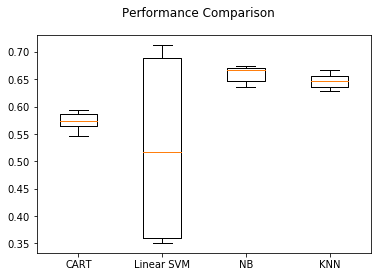

In [14]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the visual output, the performance for the KNN and NB algorithms are encouraging, with tight variance. Although the behaviour of Linear SVM is worth noticing that the variance is very large. 

## Evaluation of algorithm on Standardised Data

The performance of the few machine learning algorithm could be improved if a standardised dataset is being used. The improvement is likely for all the models. I will use pipelines that standardize the data and build the
model for each fold in the cross-validation test harness. That way we can get a fair estimation
of how each model with standardized data might perform on unseen data.

In [15]:
import warnings

# Standardize the dataset
pipelines = []

pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
                                                                        DecisionTreeClassifier())])))
pipelines.append(('ScaledLinearSVM', Pipeline([('Scaler', StandardScaler()),('Linear SVM', LinearSVC( ))])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
                                                                      GaussianNB())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
                                                                       KNeighborsClassifier())])))
results = []
names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = KFold(n_splits=num_folds, random_state=123)
    for name, model in pipelines:
        start = time.time()
        cv_results = cross_val_score(model, X_sample, Y_sample, cv=kfold, scoring='accuracy')
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

ScaledCART: 0.572500 (0.011655) (run time: 0.245938)
ScaledLinearSVM: 0.701500 (0.012698) (run time: 6.478093)
ScaledNB: 0.659400 (0.013756) (run time: 0.048999)
ScaledKNN: 0.639800 (0.008773) (run time: 1.992475)


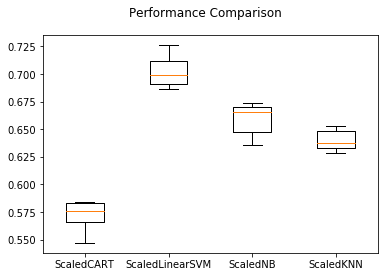

In [16]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Using scaled data, the performance of the Linear SVM improved significantly, but the other algorithms either remained roughly the same or deprove. Next, we'll fine tune the performance of Linear SVM by tuning the algorithm

## Algorithm Tuning

We will focus on the Linear SVM for the algorithm tuning. We can tune one key parameter of the SVM algorithm - the value of C. The default C for Linear SVM is 1.0. We will use the grid search method using 10-fold cross-validation with a standardized copy of the sample training dataset. We will try over a combination of C values.

In [17]:
scaler = StandardScaler().fit(X_sample)
X_sample_train_scaled = scaler.transform(X_sample)
c_values = [0.1, 0.5, 1.0, 1.5, 2.0]
kfold = KFold(n_splits=num_folds, random_state=123)
overall_mean = []
overall_std = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for c_val in c_values:
        model = LinearSVC (C=c_val)
        start = time.time()
        cv_results = cross_val_score(model, X_sample_train_scaled, Y_sample, cv=kfold, scoring='accuracy')
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print( "Linear SVC (C=%f): %f (%f) (run time: %f)" % (c_val, cv_results.mean(), cv_results.std(), end-start))
        overall_mean.append(cv_results.mean())
        overall_std.append(cv_results.std())


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Linear SVC (C=0.100000): 0.701600 (0.012729) (run time: 6.666999)
Linear SVC (C=0.500000): 0.701300 (0.012900) (run time: 6.145613)
Linear SVC (C=1.000000): 0.701300 (0.012822) (run time: 6.914358)
Linear SVC (C=1.500000): 0.701500 (0.012824) (run time: 6.109602)
Linear SVC (C=2.000000): 0.701400 (0.013253) (run time: 6.336206)


From the output, it looks like the different C values for Linear SVC does not affect the outcomes much. It is ok to just stick to the default C=1.0 value.

## Data Preparation for Machine Learning 

The main data set is now splitted into 2 - Y and X, where Y holds the target variable 'Status'. We will use 70% of the dataset for modeling and training. The remaining 30% of the dataset will be used as a hold-out set to validate the accuracy of the machine learning model. 

In [18]:
# Create arrays for the features and the response variable
Y = data['Status'].values
X = data.drop('Status', axis=1).values

In [19]:
# Create training and test sets
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.30, random_state=21)

### Application of Linear SVC on data set

In [20]:
# prepare the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = LinearSVC(C=1.0)
start = time.time()
model.fit(X_train_scaled, Y_train)
end = time.time()
print( "Run Time: %f" % (end-start))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Run Time: 63.298071


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# estimate accuracy on test dataset
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)
print("Accuracy score %f" % accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

Accuracy score 0.696911
             precision    recall  f1-score   support

          0       0.48      0.00      0.01     27269
          1       0.70      1.00      0.82     62731

avg / total       0.63      0.70      0.57     90000



In [22]:
from nltk import ConfusionMatrix
print(ConfusionMatrix(list(Y_test), list(predictions)))

  |     0     1 |
--+-------------+
0 |   <86>27183 |
1 |    95<62636>|
--+-------------+
(row = reference; col = test)



From the results above, the accuracy score of 70% is not quite an ideal outcome. From the ConfusionMatrix, the misclassification for '0' (no-show) is glaring. One very possible reason is the lack of classification patterns within the dataset, and there's a bias towards '1' (show). 

What we can do is to test the dataset using another algorithm, Gaussian Naive Bayes method. For GaussianNB() algorithm, there isn't much tuning to be done. And we will use the original unscaled data

### Application of Gausian Naive Bayes algorithm on data set

In [23]:
model = GaussianNB()
model.fit(X_train, Y_train)
predictions = model.predict(X_test_scaled)
print("Accuracy score %f" % accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

Accuracy score 0.628256
             precision    recall  f1-score   support

          0       0.35      0.26      0.29     27269
          1       0.71      0.79      0.75     62731

avg / total       0.60      0.63      0.61     90000



In [24]:
print(ConfusionMatrix(list(Y_test), list(predictions)))

  |     0     1 |
--+-------------+
0 | <6994>20275 |
1 | 13182<49549>|
--+-------------+
(row = reference; col = test)



The accuracy result for GaussianNB() is less than LinearSVC. Although the classification for '0' is better for GaussianNB, the mis-classifications for '1' have increased dramatically.

## What could be done better

The data can be tested over a SVC() instead of LinearSVC() and tested over a range of kernel functions ‘linear’, ‘poly’, ‘rbf’ or ‘sigmoid’. However, the computation of SVC over 300K rows of record with cross validation is very heavy and it takes a very long time for computation to complete on my MacBook Pro 16GB. A GPU system could be a better compute platform to do this.